Number of qubits in circuit 32
Circuit depth: 32
Number of layers: 34


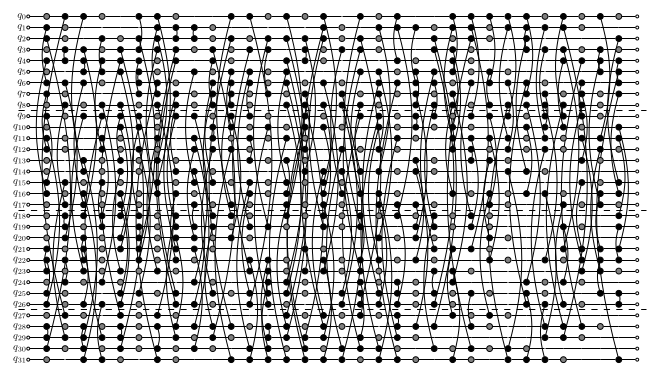

In [21]:
from qiskit.circuit.library import QFT, QuantumVolume
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from qiskit import transpile, QuantumCircuit
from QASMBench.interface.qiskit import QASMBenchmark
from disqco.graphs.quantum_network import QuantumNetwork
from disqco.parti.FM.FM_methods import set_initial_partitions
import numpy as np

num_qubits = 32

circuit = cp_fraction(num_qubits, num_qubits, fraction=0.5)

# circuit = QuantumVolume(num_qubits, num_qubits)

num_partitions = 4
 # Define the number of partitions or QPUs you will distribute over


qpu_size = num_qubits // num_partitions + 1  # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_sizes = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

# Create a quantum network with the specified number of qubits and partitions

# If we do not specificy the connectivity, we have all-to-all by default.

quantum_network = QuantumNetwork(qpu_sizes)


basis_gates = ['u', 'cp']

# Transpile the circuit to the basis gates
circuit = transpile(circuit, basis_gates=basis_gates)

print(f'Number of qubits in circuit {circuit.num_qubits}')
print(f'Circuit depth: {circuit.depth()}')

depth = circuit.depth()

from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph

base_graph = QuantumCircuitHyperGraph(circuit, group_gates=False)

from disqco.drawing import tikz_drawing



%load_ext jupyter_tikz
fig = tikz_drawing.draw_graph_tikz(base_graph, set_initial_partitions(quantum_network, num_qubits, base_graph.depth), qpu_info=qpu_sizes, show_labels=False)
display(fig)

In [22]:
from disqco.graphs.GCP_hypergraph_extended import HyperGraph

graph = HyperGraph()

graph.convert_from_GCP(base_graph)


In [23]:
import numpy as np
from disqco.parti.FM.FM_methods_ext import set_initial_partitions_extended


qubit_assignment, gate_assignment = set_initial_partitions_extended(quantum_network, graph, num_qubits, depth)





In [24]:
from disqco.parti.FM.FM_main_ext import run_FM

cost, best_assignment, cost_trace = run_FM(graph, qubit_assignment, gate_assignment, qpu_sizes, passes=10, max_gain=int(4), limit=len(graph.nodes()), stochastic=False, log=True)

print(best_assignment)

Initial cost: 163.0
Pass  0: cost = 133.0
Pass  1: cost = 131.0
Pass  2: cost = 131.0
Pass  3: cost = 131.0
Pass  4: cost = 131.0
Pass  5: cost = 131.0
Pass  6: cost = 131.0
Pass  7: cost = 131.0
Pass  8: cost = 131.0
Pass  9: cost = 131.0
(array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(32, 32)), array([[[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]],

       [[-1, -1, -1, ..., -1, -1, -1],


In [25]:
from disqco.parti.FM.FM_methods_ext import calculate_full_cost

cost = calculate_full_cost(graph, best_assignment[0], best_assignment[1], num_partitions)
print(f'Final cost: {cost}')

Final cost: 131.0


In [26]:
# fig = draw_graph_tikz_v2(graph, best_assignment[0], best_assignment[1], qpu_info=qpu_sizes, depth=depth, num_qubits=num_qubits, show_labels=False)

# display(fig)

In [27]:
from disqco.graphs.coarsening.coarsener_ext import HypergraphCoarsener

coarsener = HypergraphCoarsener()

node_list = [[i for i in range(graph.num_qubits)] for _ in range(graph.depth)]

graph_list, mapping_list = coarsener.coarsen_recursive_mapped(graph, node_list)

mapping_list = mapping_list[::-1]
qubit_assignment, gate_assignment = set_initial_partitions_extended(quantum_network, graph, num_qubits, depth)





In [28]:
from disqco.parti.FM.FM_main_ext import partition_multilevel


qubit_assignment, gate_assignment = set_initial_partitions_extended(quantum_network, graph, num_qubits, depth)

print(qubit_assignment)

min_cost, qubit_assignment, gate_assignment = partition_multilevel(graph_list, mapping_list, qubit_assignment, gate_assignment, qpu_sizes, num_partitions)
print(qubit_assignment)

print(f'Min cost: {min_cost}')

# coarse_graph = graph_list[-1]

# print(f'Qubit assignment: {qubit_assignment}')

# qubit_assignment[0][0] = 2

# print(f'Qubit assignment: {qubit_assignment}')

# new_qubit_assignment = refine_assignment(0, len(graph_list), qubit_assignment, mapping_list)

[[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Initial cost: 883.0
Pass  0: cost = 689.0
Pass  1: cost = 649.0
Pass  2: cost = 643.0
Pass  3: cost = 641.0
Pass  4: cost = 641.0
Pass  5: cost = 641.0
Pass  6: cost = 641.0
Pass  7: cost = 641.0
Pass  8: cost = 641.0
Pass  9: cost = 641.0
Refining assignment for level 0
Qubit assignment: [[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [0 0 0 ... 0 0 0]
 [2 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]]
Mapping: {0: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}}
Qubits [3 3 3 3 3 3 3 2 3 0 2 0 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0 2 3]
Qubits [3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Qubits [3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Qubits [3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Qubits [3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 1

In [29]:
# fig = draw_graph_tikz_v2(graph, qubit_assignment, gate_assignment, qpu_info=qpu_sizes, depth=depth, num_qubits=num_qubits, show_labels=False)

# display(fig)
# new_qubit_assignment = refine_assignment(0, len(graph_list), qubit_assignment, mapping_list)

cost = calculate_full_cost(graph, qubit_assignment, gate_assignment, num_partitions)
print(f'Cost: {cost}')

Cost: 354.0


In [30]:
# Example: run the Fiduccia-Mattheyses partitioner
from qiskit import QuantumCircuit
from disqco.graphs.quantum_network import QuantumNetwork
from disqco.parti.FM.fiduccia import FiducciaMattheyses

# --------------------------------------------------------------------
# 1) Build a toy circuit (replace with your own QuantumCircuit)
qc = QuantumCircuit(4)
qc.h(0)
qc.cx(0, 1)
qc.cx(2, 3)
qc.barrier()
qc.cx(1, 2)

# 2) Define a simple quantum network:
#    two QPUs that each host two physical qubits
qpu_sizes = [2, 2]                    # list or dict is accepted
network   = QuantumNetwork(qpu_sizes) # create the connectivity object

# 3) Create the FM partitioner
partitioner = FiducciaMattheyses(
    circuit = qc,
    network = network,
    initial_assignment = None          # let it build a default seed
)

# 4) Run the optimiser (single-level)
results = partitioner.partition(
    passes = 10,     # number of FM passes
    log    = True,   # print progress
    stochastic = True
)

# 5) Inspect the outcome
print("\n=== FM results ===")
print("Best cost:       ", results["best_cost"])
print("Best assignment: ", results["best_assignment"])

Number of layers: 6
Initial cost: 1
All passes complete.
Final cost: 1

=== FM results ===
Best cost:        1
Best assignment:  [[0 0 1 1]
 [0 0 1 1]
 [0 0 1 1]
 [0 0 1 1]]
